### 1. Imports

In [5]:
import torch
import pandas as pd
import numpy as np
from typing import List
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import copy
from preprocess import ArabertPreprocessor
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score, precision_score,
                             recall_score)
from torch.utils.data import DataLoader, Dataset
from transformers import (AutoConfig, AutoModelForSequenceClassification,
                          AutoTokenizer, BertTokenizer, Trainer,
                          TrainingArguments, pipeline, AutoModel)
from transformers.data.processors.utils import InputFeatures
from sklearn.model_selection import StratifiedKFold
from statistics import mean
import more_itertools
import GPUtil as GPU
import gc; 
from GPUtil import showUtilization as gpu_usage
import warnings
from math import sqrt, pow, exp
from sentence_transformers import SentenceTransformer, util
import textwrap
from beeply import notes
warnings.filterwarnings('ignore')

In [6]:
# Trying to empty the cache
print("####################### Start GPU Mointoring ###########################")
GPUs = GPU.getGPUs()        
gpu = GPUs[0]    
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print("Trying to empty the GPU ... ")
torch.cuda.empty_cache()
gc.collect()
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
print("####################### End GPU Mointoring ###########################")

####################### Start GPU Mointoring ###########################
GPU RAM Free: 6329MB | Used: 1672MB | Util  20% | Total 8192MB
Trying to empty the GPU ... 
GPU RAM Free: 6329MB | Used: 1672MB | Util  20% | Total 8192MB
####################### End GPU Mointoring ###########################


### 2. Globals

#### 2.1 Variables

In [3]:
all_datasets                = []
DATA_COLUMN                 = "text"
LABEL_COLUMN                = "label"
AUGMENTED_DATA_COLUMN       = "new_text"
AUGMENTED_DATA_COLUMN_FULL  = "all_text"
ORG_EMBD                    = "original_embbedding"
NEW_EMBD                    = "new_embbedding"
ESIM                        = "ecu_similarity"
CSIM                        = "cos_similarity"
JSIM                        = "jacc_similarity"

#### 2.2 Dataset to be Modeled

In [4]:
# select a dataset
# dataset_name = 'AJGT'
dataset_name   = "ASTD-Unbalanced"
cos_model_name = "distiluse-base-multilingual-cased"
model_name     ="aubmindlab/aragpt2-base"

In [5]:
device = 0 if torch.cuda.is_available() else -1
print(device)

0


#### 2.3 Defining ClassificationDataset Object

In [6]:
class ClassificationDataset(Dataset):
    def __init__(self, text, target, model_name, max_len, label_map):
        super(ClassificationDataset).__init__()
        """
        Args:
        text (List[str]): List of the training text
        target (List[str]): List of the training labels
        tokenizer_name (str): The tokenizer name (same as model_name).
        max_len (int): Maximum sentence length
        label_map (Dict[str,int]): A dictionary that maps the class labels to integer
        """
        self.text = text
        self.target = target
        self.tokenizer_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_len = max_len
        self.label_map = label_map
      

    def __len__(self):
        return len(self.text)

    def __getitem__(self,item):
        text = str(self.text[item])
        text = " ".join(text.split())
        inputs = self.tokenizer(
          text,
          max_length=self.max_len,
          padding='max_length',
          truncation=True
          )      
        return InputFeatures(**inputs,label=self.label_map[self.target[item]])

In [7]:
'''
	This custom dataset class will help us hold our datasets in a structred manner.	
'''
class CustomDataset:
    def __init__(
        self,
        name: str,
        train: List[pd.DataFrame],
        test: List[pd.DataFrame],
        label_list: List[str],
    ):
        """Class to hold and structure datasets.

        Args:

        name (str): holds the name of the dataset so we can select it later
        train (List[pd.DataFrame]): holds training pandas dataframe with 2 columns ["text","label"]
        test (List[pd.DataFrame]): holds testing pandas dataframe with 2 columns ["text","label"]
        label_list (List[str]): holds the list  of labels
        """
        self.name = name
        self.train = train
        self.test = test
        self.label_list = label_list

### 3. Load Datasets 

#### 3.1 HARD - Balanced

In [8]:
# df_HARD = pd.read_csv("datasets/balanced-reviews.txt", sep="\t", header=0,encoding='utf-16')
# 
# # we are interested in rating and review only
# df_HARD = df_HARD[["review","rating"]]  
# df_HARD.columns = [DATA_COLUMN, LABEL_COLUMN]
# 
# print(df_HARD[LABEL_COLUMN].value_counts())
# 
# # code rating as +ve if > 3, -ve if less, no 3s in dataset
# hard_map = {5: 'POS',4: 'POS',2: 'NEG',1: 'NEG'}
# df_HARD[LABEL_COLUMN] = df_HARD[LABEL_COLUMN].apply(lambda x: hard_map[x])
# 
# # Splits
# train_HARD, test_HARD = train_test_split(df_HARD, test_size=0.2, random_state=42)
# label_list_HARD = ['NEG', 'POS']
# 
# data_Hard = CustomDataset("HARD", train_HARD, test_HARD, label_list_HARD)
# all_datasets.append(data_Hard)

#### 3.2 AJGT 

In [9]:
# df_AJGT = pd.read_excel("datasets/AJGT.xlsx", header=0)
# 
# df_AJGT = df_AJGT[["Feed", "Sentiment"]]
# df_AJGT.columns = [DATA_COLUMN, LABEL_COLUMN]
# 
# train_AJGT, test_AJGT = train_test_split(df_AJGT, test_size=0.2, random_state=42)
# 
# print(df_AJGT[LABEL_COLUMN].value_counts())
# label_list_AJGT = list(df_AJGT[LABEL_COLUMN].unique())
# 
# data_AJGT = CustomDataset("AJGT", train_AJGT, test_AJGT, label_list_AJGT)
# all_datasets.append(data_AJGT)

#### 3.3  ASTD- Unbalanced

In [10]:
df_ASTD_UN                  = pd.read_csv("datasets/Tweets.txt", sep="\t", header=None)
df_ASTD_UN.columns          = [DATA_COLUMN, LABEL_COLUMN]
df_ASTD_UN                  = df_ASTD_UN[df_ASTD_UN[LABEL_COLUMN]!= 'OBJ']
train_ASTD_UN, test_ASTD_UN = train_test_split(df_ASTD_UN, test_size=0.2, random_state=42)
label_list_ASTD_UN          = list(df_ASTD_UN[LABEL_COLUMN].unique())
data_ASTD_UN                = CustomDataset("ASTD-Unbalanced", train_ASTD_UN, test_ASTD_UN, label_list_ASTD_UN)
all_datasets.append(data_ASTD_UN)

['POS', 'NEG', 'NEUTRAL']
NEG        1642
NEUTRAL     805
POS         777
Name: label, dtype: int64


In [ ]:
print(label_list_ASTD_UN)
print(df_ASTD_UN[LABEL_COLUMN].value_counts())

#### <p style="color:red">Datasets already loaded and Selected Dataset</p>

In [11]:
for x in all_datasets:
    print(x.name) 

ASTD-Unbalanced


In [12]:
for d in all_datasets:
    if d.name==dataset_name:
        selected_dataset = copy.deepcopy(d)
        print('Dataset found')
        break

Dataset found


#### <p style="color:red">Check the tokenized sentence length to decide on the maximum sentence length value</p>

In [13]:
tok = AutoTokenizer.from_pretrained(model_name)

Training Sentence Lengths: 


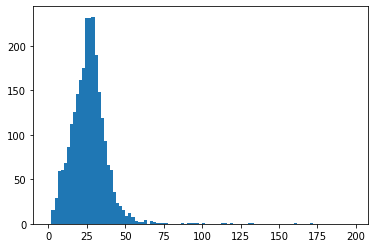

Testing Sentence Lengths: 


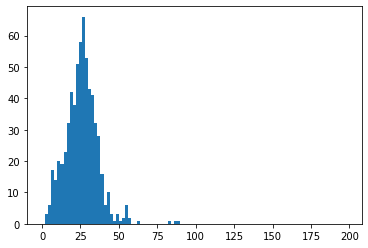

In [14]:
print("Training Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.train[DATA_COLUMN].to_list()],bins=range(0,200,2))
plt.show()

print("Testing Sentence Lengths: ")
plt.hist([ len(tok.tokenize(sentence)) for sentence in selected_dataset.test[DATA_COLUMN].to_list()],bins=range(0,200,2))
plt.show()

In [15]:
# Deciding the maximum length
max_len = 200

In [16]:
print("Truncated training sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))
print("Truncated testing sequences: ", sum([len(tok.tokenize(sentence)) > max_len for sentence in selected_dataset.test[DATA_COLUMN].to_list()]))

Truncated training sequences:  4
Truncated testing sequences:  4


### 4. Augmentation Based on Similarity

#### 4.1  Preprocessing

In [17]:
arabic_prep = ArabertPreprocessor(model_name)
selected_dataset.train[DATA_COLUMN] = selected_dataset.train[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x))
selected_dataset.test[DATA_COLUMN] = selected_dataset.test[DATA_COLUMN].apply(lambda x: arabic_prep.preprocess(x)) 

In [18]:
# Sanity check on the dataset
list(selected_dataset.train[DATA_COLUMN][0:10])

['لم تعد مصر تحتمل تكرر دوائر العنف والعنف المضاد، ولم تعد أيضا تحتمل التهاوي المرعب في قدرات الدولة',
 'مهما حاولتم إقناع أنفسكم أن الشعب إختار دستور الإخوان دون تخويف أو لعب بالدين أو إنتهاكات ستظل الحقيقة أن مرسي كذب على المصريين ليمرر دستوره',
 'دور رائع ومفاجئ لنساء مصر فى المظاهرات شبابنا ونساءنا يستحقون الصدارة ان شاء الله بعد سقوط الانقلاب',
 '5 هاتلي اخوان أي حاجة مش تنوين ومش ضمير اخوان وبعدها كلمة مش هتلاقي غير لوط وشياطين!',
 'دباسم يوسف عمل برنامج البرنامج و #فسسسسسس',
 'منذ عامين وحتى الآن كل ما قدمه أنصار تيارات الشعارات الإسلامية لمصر مجرد مشاريع خناقات مع العالم والكون وأبناء الوطن',
 '#السعاده ان يكون من نحب بخير وعافيه فنحن نشعر بهم ونهتم لامرهم حتى لو لم نراهم 3"',
 'درية شرف الدين امرأة على الوشين لا مهنية ولا اخلاق ولا وطنية ولا حياء الملايين ملأوا شوارع مصر وشاشاتها تنقل ميادين اخلاها الجيش للتصوير',
 ', جيرارد ماذا فعلت !!!!!! هل تهدم ما فعله #ليفربول😥 لو جآت من غيرگ ترا كآن هآنت أما تجي منگ يآآآهي قو…',
 '3 تم الإتصال أكثر من مرة وستكون عندنا بالغد في لجنة حقوق

#### 4.2 Defining Similarity Functions

#### <b>Notes: </b>
> <p style="color:red">Similarity is the distance between two vectors where the vector dimensions represent the features of two objects.</p>

> <p style="color:red">Similarity is the measure of how different or alike two data objects are. If the distance is small, the objects are said to have a high degree of similarity and vice versa.</p>

> <p style="color:red">Generally, it is measured in the range 0 to 1. This score in the range of [0, 1] is called the similarity score.</p>

> <p style="color:red">An important point to remember about similarity is that it’s subjective and highly dependent on the domain and use case.</p>

> <p style="color:red"><b>Jaccard index</b>, also known as Jaccard similarity coefficient,  treats the data objects like sets. It is defined as the size of the intersection of two sets divided by the size of the union. </p>

> <p style="color:red"><b>Euclidean distance</b>, or L2 norm, is the most commonly used form of the Minkowski distance. Generally speaking, when people talk about distance, they refer to Euclidean distance. It uses the Pythagoras theorem to calculate the distance between two points</p>

> <p style="color:red">In <b> Euclidean Distance, </b> the larger the distance d between two vectors, the lower the similarity score and vice versa. Moreover, the problem with using distance is that it’s hard to make sense if there is nothing to compare to. The distances can vary from 0 to infinity, therefore, we need to use some way to normalize them to the range of 0 to 1 using the Euler’s constant: </p> <b>1/(e<sup>d</sup>)</b>

> <p style="color:red"><b>Cosine Similarity</b>, computes the similarity of two vectors as the cosine of the angle between two vectors. It determines whether two vectors are pointing in roughly the same direction. So if the angle between the vectors is 0 degrees, then the cosine similarity is 1. </p>

> <p style="color:red"><b>Jaccard similarity</b><u> Takes into account only the set of unique words for each text document. This makes it the likely candidate for assessing the similarity of documents when repetition is not an issue.</u> </p>

> <p style="color:red"><b>Jaccard similarity</b><u> is rarely used when working with text data as it does not work with text embeddings. </u> This means that is limited to assessing the lexical similarity of text, i.e., how similar documents are <u>on a word level.</u> </p>

> <p style="color:red"><b>Jaccard similarity</b><u> As far as cosine and Euclidean metrics are concerned, the differentiating factor between the two is that cosine similarity is not affected by the magnitude/length of the feature vectors. </u> <b>cosine similarity is less sensitive to a difference in lengths.</b><u>In addition to that, Euclidean distance doesn’t work well with the sparse vectors of text embeddings. So cosine similarity is generally preferred over Euclidean distance when working with text data.</u> The only length-sensitive text similarity use case that comes to mind is plagiarism detection. </p>

### <u>Example:</u>

In [19]:
# Test the function (jaccard_similarity)
#sentences = ["الزجاجة فارغة","لا يوجد شيء في الزجاجة"]

In [20]:
def jaccard_similarity(x,y):
    """ returns the jaccard similarity between two lists """
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)
def squared_sum(x):
    """ return 3 rounded square rooted value """
    
    return round(sqrt(sum([a*a for a in x])),3)
 
def euclidean_distance(x,y):
    """ return euclidean distance between two lists """
    
    return sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))

def distance_to_similarity(distance):
    return 1/exp(distance)

def cos_similarity(x,y):
    """ return cosine similarity between two lists """    
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = squared_sum(x)*squared_sum(y)
    return round(numerator/float(denominator),3)

def create_arabic_embeddings (text, SentenceTransformer_model): 
    embeddings = SentenceTransformer_model.encode(list(text))
    if len(embeddings) !=0:
        return list(embeddings[0])
    else:
        return [0]

#### 4.3 Processing the Selected Dataset

In [21]:
def augment_record(text, model_name, ptm_pipeline):  
    try:        
        gen_text = ptm_pipeline(text[:200],
                pad_token_id=0, # 0 for AraGPT2
                num_beams=5,
                max_length=200,
                top_p=0.95,
                repetition_penalty = 3.0,
                no_repeat_ngram_size = 3)[0]['generated_text']
        
    except:
        print('Failure during augmenting the record : '  + text)        
    
    return gen_text

In [22]:
SentenceTransformer_model = SentenceTransformer(cos_model_name) 
m            = 'aubmindlab/aragpt2-base'
df           = pd.DataFrame()
newDF        = pd.DataFrame()
df           = selected_dataset.train.append(selected_dataset.test)
#df.reset_index(inplace=True)
ptm_pipeline = pipeline("text-generation",model=m,device=device, is_decoder=True)
arabic_prep  = ArabertPreprocessor(m)
cntr         = 1

for index, row in df.iterrows():
    print('Rows Counter: ' + str(cntr))
    text     = arabic_prep.preprocess(row[DATA_COLUMN])
    gen_text = augment_record(text, model_name=m, ptm_pipeline=ptm_pipeline)       
    new_text = gen_text[len(text):200]
    all_text = gen_text        
    embd1 = create_arabic_embeddings(text=text, SentenceTransformer_model=SentenceTransformer_model)
    embd2 = create_arabic_embeddings(text=new_text, SentenceTransformer_model=SentenceTransformer_model)      
    new_embd1 = ','.join(str(x) for x in embd1)
    new_embd2 = ','.join(str(x) for x in embd2)
    esim = euclidean_distance(embd1, embd2)
    csim = cos_similarity(embd1, embd2)
    jsim = jaccard_similarity(text[:200], new_text)    
    tmpDF = { 'text': row[DATA_COLUMN], 'label': row[LABEL_COLUMN], 'new_text': new_text, 'all_text': all_text, 'original_embbedding': new_embd1,'new_embbedding': new_embd2,'ecu_similarity': esim,'cos_similarity':csim,'jacc_similarity':jsim }
    newDF = newDF.append(tmpDF, ignore_index = True)  
    
    cntr = cntr + 1
    #if cntr == 10:
    #    break;
        
    # GPU Monitor
    if index%10 == 0:
        GPUs = GPU.getGPUs()  
        gpu = GPUs[0]    
        print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))        
        torch.cuda.empty_cache()


Rows Counter: 1
Rows Counter: 2
Rows Counter: 3
GPU RAM Free: 5137MB | Used: 2873MB | Util  35% | Total 8192MB
Rows Counter: 4
Rows Counter: 5
Rows Counter: 6
Rows Counter: 7
Rows Counter: 8
Rows Counter: 9
Rows Counter: 10
Rows Counter: 11
GPU RAM Free: 5030MB | Used: 2980MB | Util  36% | Total 8192MB
Rows Counter: 12
Rows Counter: 13
GPU RAM Free: 5118MB | Used: 2892MB | Util  35% | Total 8192MB
Rows Counter: 14
Rows Counter: 15
Rows Counter: 16
Rows Counter: 17
Rows Counter: 18
Rows Counter: 19
GPU RAM Free: 5145MB | Used: 2865MB | Util  35% | Total 8192MB
Rows Counter: 20
Rows Counter: 21
Rows Counter: 22
Rows Counter: 23
Rows Counter: 24
Rows Counter: 25
Rows Counter: 26
Rows Counter: 27
Rows Counter: 28
Rows Counter: 29
Rows Counter: 30
Rows Counter: 31
Rows Counter: 32
Rows Counter: 33
Rows Counter: 34
Rows Counter: 35
Rows Counter: 36
Rows Counter: 37
Rows Counter: 38
Rows Counter: 39
GPU RAM Free: 4999MB | Used: 3011MB | Util  37% | Total 8192MB
Rows Counter: 40
Rows Counter: 

Rows Counter: 361
Rows Counter: 362
Rows Counter: 363
Rows Counter: 364
Rows Counter: 365
GPU RAM Free: 5134MB | Used: 2876MB | Util  35% | Total 8192MB
Rows Counter: 366
Rows Counter: 367
Rows Counter: 368
Rows Counter: 369
Rows Counter: 370
Rows Counter: 371
Rows Counter: 372
Rows Counter: 373
Rows Counter: 374
Rows Counter: 375
Rows Counter: 376
Rows Counter: 377
Rows Counter: 378
Rows Counter: 379
Rows Counter: 380
Rows Counter: 381
Rows Counter: 382
Rows Counter: 383
Rows Counter: 384
Rows Counter: 385
Rows Counter: 386
Rows Counter: 387
Rows Counter: 388
Rows Counter: 389
Rows Counter: 390
Rows Counter: 391
Rows Counter: 392
Rows Counter: 393
Rows Counter: 394
Rows Counter: 395
Rows Counter: 396
Rows Counter: 397
Rows Counter: 398
Rows Counter: 399
Rows Counter: 400
Rows Counter: 401
Rows Counter: 402
Rows Counter: 403
Rows Counter: 404
Rows Counter: 405
GPU RAM Free: 5038MB | Used: 2972MB | Util  36% | Total 8192MB
Rows Counter: 406
Rows Counter: 407
Rows Counter: 408
Rows Count

Rows Counter: 713
GPU RAM Free: 5081MB | Used: 2929MB | Util  36% | Total 8192MB
Rows Counter: 714
Rows Counter: 715
GPU RAM Free: 5134MB | Used: 2876MB | Util  35% | Total 8192MB
Rows Counter: 716
GPU RAM Free: 5139MB | Used: 2871MB | Util  35% | Total 8192MB
Rows Counter: 717
Rows Counter: 718
GPU RAM Free: 5150MB | Used: 2860MB | Util  35% | Total 8192MB
Rows Counter: 719
Rows Counter: 720
Rows Counter: 721
Rows Counter: 722
Rows Counter: 723
Rows Counter: 724
Rows Counter: 725
Rows Counter: 726
Rows Counter: 727
Rows Counter: 728
GPU RAM Free: 5057MB | Used: 2953MB | Util  36% | Total 8192MB
Rows Counter: 729
GPU RAM Free: 5227MB | Used: 2783MB | Util  34% | Total 8192MB
Rows Counter: 730
Rows Counter: 731
Rows Counter: 732
GPU RAM Free: 5139MB | Used: 2871MB | Util  35% | Total 8192MB
Rows Counter: 733
Rows Counter: 734
Rows Counter: 735
Rows Counter: 736
Rows Counter: 737
Rows Counter: 738
Rows Counter: 739
Rows Counter: 740
GPU RAM Free: 5136MB | Used: 2874MB | Util  35% | Total

Rows Counter: 1021
GPU RAM Free: 5114MB | Used: 2896MB | Util  35% | Total 8192MB
Rows Counter: 1022
Rows Counter: 1023
Rows Counter: 1024
Rows Counter: 1025
Rows Counter: 1026
Rows Counter: 1027
Rows Counter: 1028
Rows Counter: 1029
Rows Counter: 1030
Rows Counter: 1031
Rows Counter: 1032
Rows Counter: 1033
Rows Counter: 1034
Rows Counter: 1035
Rows Counter: 1036
Rows Counter: 1037
GPU RAM Free: 5093MB | Used: 2917MB | Util  36% | Total 8192MB
Rows Counter: 1038
GPU RAM Free: 5126MB | Used: 2884MB | Util  35% | Total 8192MB
Rows Counter: 1039
Rows Counter: 1040
Rows Counter: 1041
Rows Counter: 1042
Rows Counter: 1043
Rows Counter: 1044
Rows Counter: 1045
Rows Counter: 1046
Rows Counter: 1047
Rows Counter: 1048
Rows Counter: 1049
GPU RAM Free: 5098MB | Used: 2912MB | Util  36% | Total 8192MB
Rows Counter: 1050
Rows Counter: 1051
Rows Counter: 1052
Rows Counter: 1053
Rows Counter: 1054
Rows Counter: 1055
Rows Counter: 1056
Rows Counter: 1057
GPU RAM Free: 5125MB | Used: 2885MB | Util  3

GPU RAM Free: 5099MB | Used: 2911MB | Util  36% | Total 8192MB
Rows Counter: 1327
Rows Counter: 1328
Rows Counter: 1329
Rows Counter: 1330
Rows Counter: 1331
Rows Counter: 1332
Rows Counter: 1333
GPU RAM Free: 5069MB | Used: 2941MB | Util  36% | Total 8192MB
Rows Counter: 1334
Rows Counter: 1335
Rows Counter: 1336
Rows Counter: 1337
Rows Counter: 1338
Rows Counter: 1339
GPU RAM Free: 5142MB | Used: 2868MB | Util  35% | Total 8192MB
Rows Counter: 1340
Rows Counter: 1341
Rows Counter: 1342
Rows Counter: 1343
Rows Counter: 1344
Rows Counter: 1345
Rows Counter: 1346
Rows Counter: 1347
Rows Counter: 1348
Rows Counter: 1349
Rows Counter: 1350
Rows Counter: 1351
Rows Counter: 1352
Rows Counter: 1353
Rows Counter: 1354
Rows Counter: 1355
Rows Counter: 1356
Rows Counter: 1357
Rows Counter: 1358
Rows Counter: 1359
Rows Counter: 1360
Rows Counter: 1361
Rows Counter: 1362
Rows Counter: 1363
Rows Counter: 1364
Rows Counter: 1365
Rows Counter: 1366
Rows Counter: 1367
Rows Counter: 1368
Rows Counter:

Rows Counter: 1649
Rows Counter: 1650
Rows Counter: 1651
Rows Counter: 1652
Rows Counter: 1653
Rows Counter: 1654
Rows Counter: 1655
Rows Counter: 1656
Rows Counter: 1657
Rows Counter: 1658
Rows Counter: 1659
Rows Counter: 1660
Rows Counter: 1661
GPU RAM Free: 5001MB | Used: 3009MB | Util  37% | Total 8192MB
Rows Counter: 1662
Rows Counter: 1663
Rows Counter: 1664
Rows Counter: 1665
Rows Counter: 1666
Rows Counter: 1667
Rows Counter: 1668
Rows Counter: 1669
Rows Counter: 1670
Rows Counter: 1671
Rows Counter: 1672
Rows Counter: 1673
Rows Counter: 1674
Rows Counter: 1675
Rows Counter: 1676
Rows Counter: 1677
Rows Counter: 1678
Rows Counter: 1679
Rows Counter: 1680
Rows Counter: 1681
Rows Counter: 1682
Rows Counter: 1683
GPU RAM Free: 5016MB | Used: 2994MB | Util  37% | Total 8192MB
Rows Counter: 1684
Rows Counter: 1685
Rows Counter: 1686
Rows Counter: 1687
Rows Counter: 1688
Rows Counter: 1689
Rows Counter: 1690
Rows Counter: 1691
Rows Counter: 1692
Rows Counter: 1693
Rows Counter: 1694


GPU RAM Free: 4986MB | Used: 3024MB | Util  37% | Total 8192MB
Rows Counter: 1991
Rows Counter: 1992
Rows Counter: 1993
Rows Counter: 1994
Rows Counter: 1995
Rows Counter: 1996
Rows Counter: 1997
Rows Counter: 1998
Rows Counter: 1999
Rows Counter: 2000
Rows Counter: 2001
Rows Counter: 2002
Rows Counter: 2003
Rows Counter: 2004
Rows Counter: 2005
Rows Counter: 2006
Rows Counter: 2007
Rows Counter: 2008
Rows Counter: 2009
Rows Counter: 2010
Rows Counter: 2011
Rows Counter: 2012
GPU RAM Free: 5013MB | Used: 2997MB | Util  37% | Total 8192MB
Rows Counter: 2013
Rows Counter: 2014
Rows Counter: 2015
Rows Counter: 2016
Rows Counter: 2017
Rows Counter: 2018
Rows Counter: 2019
GPU RAM Free: 5052MB | Used: 2958MB | Util  36% | Total 8192MB
Rows Counter: 2020
Rows Counter: 2021
Rows Counter: 2022
GPU RAM Free: 5146MB | Used: 2864MB | Util  35% | Total 8192MB
Rows Counter: 2023
Rows Counter: 2024
Rows Counter: 2025
Rows Counter: 2026
Rows Counter: 2027
Rows Counter: 2028
Rows Counter: 2029
Rows Co

Rows Counter: 2327
Rows Counter: 2328
Rows Counter: 2329
Rows Counter: 2330
Rows Counter: 2331
Rows Counter: 2332
Rows Counter: 2333
Rows Counter: 2334
Rows Counter: 2335
Rows Counter: 2336
Rows Counter: 2337
Rows Counter: 2338
Rows Counter: 2339
Rows Counter: 2340
Rows Counter: 2341
Rows Counter: 2342
Rows Counter: 2343
Rows Counter: 2344
Rows Counter: 2345
Rows Counter: 2346
Rows Counter: 2347
Rows Counter: 2348
Rows Counter: 2349
Rows Counter: 2350
Rows Counter: 2351
Rows Counter: 2352
GPU RAM Free: 5044MB | Used: 2966MB | Util  36% | Total 8192MB
Rows Counter: 2353
Rows Counter: 2354
Rows Counter: 2355
Rows Counter: 2356
Rows Counter: 2357
GPU RAM Free: 5087MB | Used: 2923MB | Util  36% | Total 8192MB
Rows Counter: 2358
Rows Counter: 2359
Rows Counter: 2360
GPU RAM Free: 5130MB | Used: 2880MB | Util  35% | Total 8192MB
Rows Counter: 2361
Rows Counter: 2362
Rows Counter: 2363
Rows Counter: 2364
Rows Counter: 2365
Rows Counter: 2366
Rows Counter: 2367
Rows Counter: 2368
Rows Counter:

GPU RAM Free: 5081MB | Used: 2929MB | Util  36% | Total 8192MB
Rows Counter: 2666
Rows Counter: 2667
GPU RAM Free: 5145MB | Used: 2865MB | Util  35% | Total 8192MB
Rows Counter: 2668
Rows Counter: 2669
Rows Counter: 2670
Rows Counter: 2671
Rows Counter: 2672
Rows Counter: 2673
Rows Counter: 2674
Rows Counter: 2675
GPU RAM Free: 5093MB | Used: 2917MB | Util  36% | Total 8192MB
Rows Counter: 2676
Rows Counter: 2677
Rows Counter: 2678
Rows Counter: 2679
GPU RAM Free: 5107MB | Used: 2903MB | Util  35% | Total 8192MB
Rows Counter: 2680
Rows Counter: 2681
Rows Counter: 2682
Rows Counter: 2683
Rows Counter: 2684
Rows Counter: 2685
Rows Counter: 2686
Rows Counter: 2687
Rows Counter: 2688
Rows Counter: 2689
Rows Counter: 2690
Rows Counter: 2691
Rows Counter: 2692
Rows Counter: 2693
Rows Counter: 2694
Rows Counter: 2695
Rows Counter: 2696
Rows Counter: 2697
Rows Counter: 2698
GPU RAM Free: 5027MB | Used: 2983MB | Util  36% | Total 8192MB
Rows Counter: 2699
Rows Counter: 2700
Rows Counter: 2701
R

Rows Counter: 2995
Rows Counter: 2996
Rows Counter: 2997
Rows Counter: 2998
Rows Counter: 2999
Rows Counter: 3000
Rows Counter: 3001
Rows Counter: 3002
Rows Counter: 3003
Rows Counter: 3004
Rows Counter: 3005
Rows Counter: 3006
Rows Counter: 3007
Rows Counter: 3008
Rows Counter: 3009
Rows Counter: 3010
Rows Counter: 3011
Rows Counter: 3012
Rows Counter: 3013
Rows Counter: 3014
Rows Counter: 3015
Rows Counter: 3016
Rows Counter: 3017
Rows Counter: 3018
Rows Counter: 3019
Rows Counter: 3020
Rows Counter: 3021
Rows Counter: 3022
Rows Counter: 3023
Rows Counter: 3024
Rows Counter: 3025
GPU RAM Free: 4957MB | Used: 3053MB | Util  37% | Total 8192MB
Rows Counter: 3026
Rows Counter: 3027
Rows Counter: 3028
Rows Counter: 3029
Rows Counter: 3030
GPU RAM Free: 5097MB | Used: 2913MB | Util  36% | Total 8192MB
Rows Counter: 3031
Rows Counter: 3032
Rows Counter: 3033
Rows Counter: 3034
Rows Counter: 3035
Rows Counter: 3036
Rows Counter: 3037
Rows Counter: 3038
Rows Counter: 3039
GPU RAM Free: 5039M

In [23]:
# Export dataset  
newDF.to_csv( "Augmented-Dataset/" + selected_dataset.name + "-Augmented-" + m.split('/')[1] + ".csv", sep="\t", header=0,encoding='utf-16', index=False)

In [24]:
mybeep = notes.beeps(10000)
mybeep.hear('C',2000)

In [25]:
newDF

,text,label,new_text,all_text,original_embbedding,new_embbedding,ecu_similarity,cos_similarity,jacc_similarity
0,لم تعد مصر تحتمل تكرر دوائر العنف والعنف المضا...,NEG,المصرية على مواجهة التحديات الداخلية والخارجية.,لم تعد مصر تحتمل تكرر دوائر العنف والعنف المضا...,"0.017838204,0.007064947,-0.03709342,-0.0264731...","0.017580774,-0.0027376045,-0.03825421,-0.04189...",0.300106,0.899,0.518519
1,مهما حاولتم إقناع أنفسكم أن الشعب إختار دستور ...,NEG,الباطل.إذا كانت هذه هي زيارتك الأولى ، كن متأ...,مهما حاولتم إقناع أنفسكم أن الشعب إختار دستور ...,"0.026780926,0.009709039,-0.030822175,-0.033138...","0.017580774,-0.0027376045,-0.03825421,-0.04189...",0.297531,0.897,0.580645
2,دور رائع ومفاجئ لنساء مصر فى المظاهرات شبابنا ...,POS,العسكرى...تأكيد الحوار ونبذ الإقصاء وخطاب الك...,دور رائع ومفاجئ لنساء مصر فى المظاهرات شبابنا ...,"0.016909812,0.015640503,-0.02446039,-0.0235670...","0.017580774,-0.0027376045,-0.03825421,-0.04189...",0.390541,0.834,0.656250
3,5 هاتلي اخوان أي حاجة مش تنوين ومش ضمير اخوان ...,NEG,!!.,5 هاتلي اخوان أي حاجة مش تنوين ومش ضمير اخوان ...,"0.014882844,-0.051557414,-0.028316082,0.014168...","0.01946623,-0.010952667,-0.039843258,-0.057320...",0.772223,0.446,0.037037
4,دباسم يوسف عمل برنامج البرنامج و #فسسسسسس,NEG,لر على # الفيس _ بوك [رابط]بسم الله الرحمن الر...,دباسم يوسف عمل برنامج البرنامج و # فسسلر على #...,"0.016909812,0.015640503,-0.02446039,-0.0235670...","0.017838204,0.007064947,-0.03709342,-0.0264731...",0.205765,0.929,0.437500
...,...,...,...,...,...,...,...,...,...
3219,الوصف الحقيقي للميدان هو / جماعة الإخوان المسل...,NEG,وتها لمقاطعة إنتخابات الرئاسة.,الوصف الحقيقي للميدان هو - جماعة الإخوان المسل...,"0.036414325,0.028412146,-0.037543822,-0.037372...","0.028928587,0.004078342,-0.040572416,-0.024466...",0.277303,0.926,0.580645
3220,الأسواني:لماذا تصر الولايات المتحدة على استمرا...,NEG,السلمية ؟!,الأسواني : لماذا تصر الولايات المتحدة على استم...,"0.036414325,0.028412146,-0.037543822,-0.037372...","0.017580768,-0.0027376027,-0.03825421,-0.04189...",0.328126,0.891,0.269231
3221,الشاات بااايظ ليه يا #مارك -_-,NEG,ياابن.. [رابط]لوحة التحكم الرسائل الخاصة الإش...,الشاات باايظ ليه يا # مارك - _ - ياابن.. [رابط...,"0.036414325,0.028412146,-0.037543822,-0.037372...","0.017580774,-0.0027376045,-0.03825421,-0.04189...",0.328126,0.891,0.275000
3222,مواليد برج #الأسد تعجبك صداقتهم كثيراً,POS,، لكن هناك من لا يريدك أن تكون صديقهم. إذا كن...,مواليد برج # الأسد تعجبك صداقتهم كثيرا ، لكن ه...,"0.026780926,0.009709039,-0.030822175,-0.033138...","0.017580774,-0.0027376045,-0.03825421,-0.04189...",0.297531,0.897,0.555556
